In [48]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import regularizers


In [49]:
# Define network and training parameters
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 64
BUFFER_SIZE = 250  # Increased buffer size for better shuffling
LEARNING_RATE = 0.0001  # Reduced learning rate

In [50]:
# Actualiza la ruta a tu nuevo dataset
images_dir = 'processed_dataset'

In [51]:
# Definir rutas de entrenamiento y validación
train_dir = os.path.join(images_dir, 'train')
valid_dir = os.path.join(images_dir, 'valid')

In [52]:
# Obtener las clases (subdirectorios) y asignar etiquetas numéricas
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}

In [53]:
print(f"Clases encontradas: {class_names}")

Clases encontradas: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']


In [54]:
# Crear listas para almacenar rutas y etiquetas para entrenamiento
train_image_paths = []
train_labels = []

for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            train_image_paths.append(os.path.join(class_dir, fname))
            train_labels.append(class_to_label[class_name])


In [55]:
# Crear listas para almacenar rutas y etiquetas para validación
valid_image_paths = []
valid_labels = []

for class_name in class_names:
    class_dir = os.path.join(valid_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            valid_image_paths.append(os.path.join(class_dir, fname))
            valid_labels.append(class_to_label[class_name])


In [56]:
# Crear DataFrames
train_df_balanced = pd.DataFrame({
    'filepath': train_image_paths,
    'label': train_labels
})

In [57]:
val_df = pd.DataFrame({
    'filepath': valid_image_paths,
    'label': valid_labels
})

In [58]:
print(f"Distribución de clases en entrenamiento:\n{train_df_balanced['label'].value_counts()}")
print(f"Distribución de clases en validación:\n{val_df['label'].value_counts()}")

Distribución de clases en entrenamiento:
label
3    801
2    468
0    464
1    292
4    177
Name: count, dtype: int64
Distribución de clases en validación:
label
3    200
2    168
0    165
1     81
4     44
Name: count, dtype: int64


In [59]:
# Definir data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [60]:
# Función para cargar y preprocesar imágenes
def load_and_preprocess_image_flexible(path, label):
    try:
        image = tf.io.read_file(path)
        file_extension = tf.strings.lower(tf.strings.split(path, '.')[-1])
        image = tf.case([
            (tf.equal(file_extension, 'jpg'), lambda: tf.image.decode_jpeg(image, channels=3)),
            (tf.equal(file_extension, 'jpeg'), lambda: tf.image.decode_jpeg(image, channels=3)),
            (tf.equal(file_extension, 'png'), lambda: tf.image.decode_png(image, channels=3)),
        ], default=lambda: tf.image.decode_jpeg(image, channels=3), exclusive=True)
        image = tf.image.resize(image, IMAGE_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        image = data_augmentation(image)
        return image, label
    except tf.errors.InvalidArgumentError:
        tf.print(f"Error al procesar la imagen: {path}")
        return tf.zeros(INPUT_SHAPE), -1

In [61]:
# Crear TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df_balanced['filepath'].values, train_df_balanced['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['filepath'].values, val_df['label'].values))

train_ds = train_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
# Verificar los datasets
for images, labels in train_ds.take(1):
    print(f"Batch de entrenamiento - imágenes: {images.shape}, etiquetas: {labels.shape}")

for images, labels in val_ds.take(1):
    print(f"Batch de validación - imágenes: {images.shape}, etiquetas: {labels.shape}")

Batch de entrenamiento - imágenes: (64, 128, 128, 3), etiquetas: (64,)
Batch de validación - imágenes: (64, 128, 128, 3), etiquetas: (64,)


In [63]:
# Cargar el modelo base (MobileNetV2)
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [64]:
base_model.trainable = False  # Congelar las capas del modelo base

In [65]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Agregar softmax si no se usa from_logits
])


In [66]:
# Compilar el modelo con una tasa de aprendizaje fija
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [67]:
# Definir callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_path = 'best_model.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
tensorboard_log_dir = "logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [68]:
# Entrenamiento del modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard_callback]
)


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.2138 - loss: 3.7114
Epoch 1: val_loss improved from inf to 2.71753, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.2128 - loss: 3.7178 - val_accuracy: 0.3419 - val_loss: 2.7175 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2397 - loss: 3.2096
Epoch 2: val_loss improved from 2.71753 to 2.61759, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 915ms/step - accuracy: 0.2404 - loss: 3.2076 - val_accuracy: 0.3739 - val_loss: 2.6176 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.2230 - loss: 3.0394
Epoch 3: val_loss improved from 2.61759 to 2.50214, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2249 - loss: 3.0354 - val_accuracy: 0.4088 - val_loss: 2.5021 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accur

KeyboardInterrupt: 

In [22]:
# Evaluar el modelo en el conjunto de validación
test_results = model.evaluate(val_ds, return_dict=True)
print("Resultados de evaluación en test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.5908 - loss: 1.3800
Resultados de evaluación en test set:
accuracy: 0.6535
loss: 1.2961


In [23]:
# Obtener predicciones
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step


In [24]:
# Obtener etiquetas verdaderas
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [25]:
# Calcular la matriz de confusión
conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes).numpy()

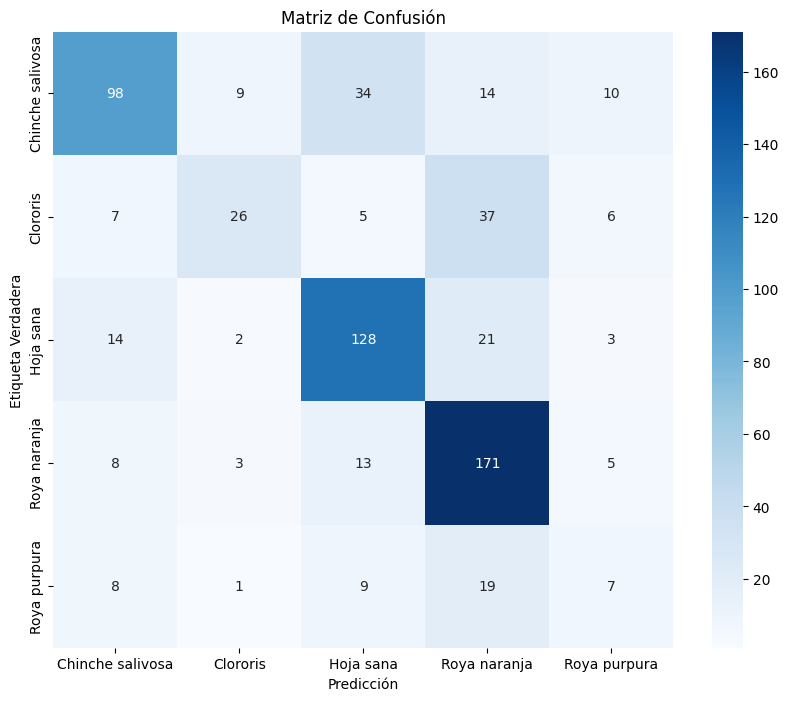

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.73      0.59      0.65       165
        Clororis       0.63      0.32      0.43        81
       Hoja sana       0.68      0.76      0.72       168
    Roya naranja       0.65      0.85      0.74       200
    Roya purpura       0.23      0.16      0.19        44

        accuracy                           0.65       658
       macro avg       0.58      0.54      0.54       658
    weighted avg       0.65      0.65      0.64       658



In [26]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))